Copyright 2019 Intel Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Introduction

In Lesson 3 of *Anomaly Detection: Linear Methods*, we learned about linear methods used for anomaly detection: linear regression, principal component analysis (PCA) and one-class support vector machines (SVMs).

Here will apply all three techniques to detect anomalies in synthetic and real-world data.

# Learning Outcomes

You should walk away from this Python tutorial with:
1. Practical experience with linear regression models
2. Practical experience with PCA
3. Practical experience with one-class SVMs 

# Imports

In [2]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)

import sys
import matplotlib.pyplot as plt
import sklearn.decomposition as decomp
import sklearn.linear_model as linear_model
import sklearn.datasets as sk_data
from sklearn.preprocessing import StandardScaler
import numpy.linalg as nla
import sklearn.svm as svm
import pandas as pd

# Python and library versions

In [3]:
packages = [np]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]

library .      version
-------        -------
numpy           1.16.4


# Section 1: Linear regression models

In this section, we are going to use synthetic datasets to detect  anomalies using a linear regression. We'll apply what we've learned to a real-world dataset in the exercises.

The key idea: deviation from regression model--that is, the difference between the actual value and the prediction value--is a measure of how anomalous a point is.

A reminder of how linear regression models is used for anomaly detection: 

1. Split data into train and test datasets
2. Use train data sets to (i) get the parameters of the regression model and (ii) determine the threshold for anomalies
3. Apply the results to the test data to detect anomalies


### Data

Here we will work with the data shown in the lecture: exam grade and hours studied.

In [4]:
# Approximately linear data
exam_data1 = np.array([[1, 2, 3, 4, 5],
                    [57, 70, 76, 84, 91]]).T
print(exam_data1)

[[ 1 57]
 [ 2 70]
 [ 3 76]
 [ 4 84]
 [ 5 91]]


For each pair of data points, the first value is the hours studies and the second is the exam grade (out of 100).

In [5]:
# One anomaly replaces a normal point
exam_data2 = np.array([[1, 2, 3, 4, 5],
                      [57, 70, 99, 84, 91]]).T
print(exam_data2)

[[ 1 57]
 [ 2 70]
 [ 3 99]
 [ 4 84]
 [ 5 91]]


The anomaly is (3, 99).

To simplify our work, we will introduce a helper function that plots a straight line given the slope, intercept, axes (to create the figure) and the style of the line (to plot multiple lines on the same graph).

In [6]:
def plot_mb(m, b, ax, style):
    'plot a line y=mx+b on a matplotlib axis'
    xs = ax.get_xlim()
    ax.plot(xs, m*xs + b, style) #style is type of line

### Analysis 

Plot the two datasets together so we can easily compare them.

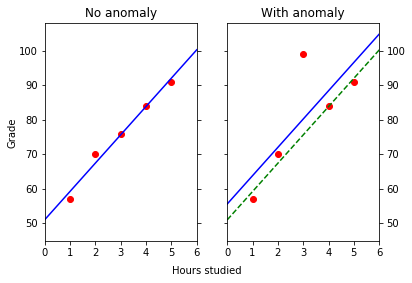

In [7]:
fig, axes = plt.subplots(1,2,sharex=True)

# Modify axes so they look nice
axes[0].set_xlim([0, 6.01])
start_x, end_x = axes[0].get_xlim()
stepsize_x = 1
axes[0].xaxis.set_ticks(np.arange(start_x, end_x, stepsize_x))
axes[0].yaxis.set_ticks_position('both')
axes[0].set_ylim([45, 108])
axes[1].set_ylim(axes[0].get_ylim())
axes[1].yaxis.tick_right() # Display tick values on the right for clarity
axes[1].yaxis.set_ticks_position('both')

# Fit a straight straight line to the linear data
lr = linear_model.LinearRegression().fit(exam_data1[:,0:1],
                                         exam_data1[:,1])
axes[0].plot(*exam_data1.T, 'ro')
plot_mb(lr.coef_, lr.intercept_, axes[0], 'b-' )

# Fit a straight straight line to data with anomaly
lr2 = linear_model.LinearRegression().fit(exam_data2[:,0:1],
                                         exam_data2[:,1])
axes[1].plot(*exam_data2.T, 'ro')

# Plot two linear fits: from data with anomaly and from normal data
plot_mb(lr2.coef_, lr2.intercept_, axes[1], 'b-')
plot_mb(lr.coef_, lr.intercept_, axes[1], 'g--')

axes[0].set_title('No anomaly')
axes[1].set_title('With anomaly')
fig.text(0.5, 0.02, 'Hours studied', ha='center', va='center')
fig.text(0.05, 0.5, 'Grade', ha='center', va='center', rotation='vertical')
plt.show()

As we can see, all of the data on the left lies close to the regression model (blue line), while for the data on the right we can see that there is a point that is far from the line. This point (3, 99) is the anomaly.

**Note:** There are two lines in the panel on the right: the regression model for the data with the anomaly (solid blue line) and the one found from the normal data from the left panel (dashed green line). The difference between these two lines is due to the anomaly itself (all other points are unchanged). That is, anomalies affect the regression model.

It is because anomalies affect the regression model that we do the train/test split to ensure that the linear fit reflects only the normal data. Of course, such an approach presumes that we can have (or can create) a training set with only normal data.    

We will now treat 'exam_data1' (no anomaly) as the train dataset and 'exame_data2' (with anomaly) as the test dataset.

First, we fit our train dataset. We will use the _LinearRegression_ function from_sklearn_ as we did above. Recall from the anomaly score is the square of the residual for each point.

In [8]:
ftrs, tgt = exam_data1[:,0:1], exam_data1[:,1]
lr_train = linear_model.LinearRegression().fit(ftrs, tgt)
print(f'Slope: {lr_train.coef_}')
print(f'Intercept: {lr_train.intercept_:.{3}}')
train_scores = (tgt - lr_train.predict(ftrs))**2 
print(train_scores)

Slope: [8.2]
Intercept: 51.0
[4.84 6.76 0.16 0.04 1.  ]


Let's set the threshold for anomaly detection to be the just above the maximum score from the train dataset.

In [9]:
margin = 0.01
threshold = max(train_scores) + margin
print(f'Threshold: {threshold:.{3}}')

Threshold: 6.77


Now let's calculate the anomaly scores for the test data.

In [10]:
def do_linreg_anomaly_scores(train, test):
    ftrs, tgt = train[:,0:1], train[:,1]
    lr_train = linear_model.LinearRegression().fit(ftrs, tgt)
    anom_score = (test[:,1] - lr_train.predict(test[:,0:1]))**2
    return anom_score

In [11]:
print(do_linreg_anomaly_scores(exam_data1, exam_data2))

[  4.84   6.76 547.56   0.04   1.  ]


We see that the middle point (index=2) exceeds the threshold. It is the anomaly we introduced into the data. As a check, we can compare the anomaly score above with those of the training data.

In [12]:
print(train_scores)

[4.84 6.76 0.16 0.04 1.  ]


As expected, the two sets of scores differ only for the anomalous point.

# Section 2: Principal component analysis (PCA)

In this section, we are going to use synthetic datasets to detect  anomalies using PCA. We'll apply what we've learned to a real-world dataset in the exercises.

How to calculate PCA-based anomaly scores:

  1. Preprocess the data (if needed)
  2. Compute the principal components (PCs) of the centered data
  3. Project our examples onto the PCs
  4. Calculate the distance between the original and the projected examples
  5. Use the distance to score the anomalies


### Data

We start with the data shown in the lecture: a simple 2D dataset of synthetic data: ($X_1, X_2$). To demonstrate how PCA works, we take $X_2 = X_1/2$ for all pairs except one. where we made a small change: (0.5, 0.26). This point is the anomaly.

In [13]:
pca_example = np.array([[-3, -1.5], [-2.5, -1.25], [-1.5, -0.75], 
                        [-1, -0.5], [-0.5, -0.25], [0, 0], [0.5, 0.26], 
                        [1, 0.5],  [1.5, 0.75], [2.5, 1.25], [3, 1.5]])

What is the mean of the data?

In [14]:
mean_pca_example = np.mean(pca_example, axis=0, keepdims=True)
mean_pca_example

array([[0.    , 0.0009]])

What about the variance? We want to make sure that the variance in each direction is approximately equal (otherwise something trivial, like changing the unit of measurement from meters to millimeters, will drastically change the principal components).

In [15]:
var_pca_example = np.var(pca_example, axis=0, keepdims=True)
var_pca_example

array([[3.4091, 0.8527]])

Since mean of this data is (practically) zero, we don't need to do mean subtraction. We should correct for the different variances, however. The typical approach is to divide each component by its standard deviation, enforcing the variance in each direction is 1.

In [16]:
scaled_pca_example = pca_example/np.sqrt(var_pca_example)

# show the variances are equal
scaled_pca_example.var(axis=0)

array([1., 1.])

Let's plot the original (i.e. _unscaled_) data

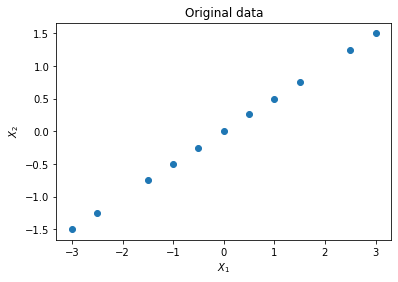

In [17]:
fig, ax = plt.subplots()
ax.scatter(pca_example[:,0], pca_example[:,1])
ax.set_ylabel('$X_2$')
ax.set_xlabel('$X_1$')
ax.set_title('Original data')
plt.show()

Can you spot the anomaly?

To show what PCA can do, we will apply it to our dataset and take a sneak peek at the results (using PCA from *sklearn*). We expect the first principal component to lie along the $X_2 = X_1/2$ line because that is the direction along which the data varies the most. And given the way we constructed the dataset, there will be almost no variation along the second principal component except for the anomaly.

In [18]:
pca = decomp.PCA(n_components=2)
pca.fit(scaled_pca_example)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

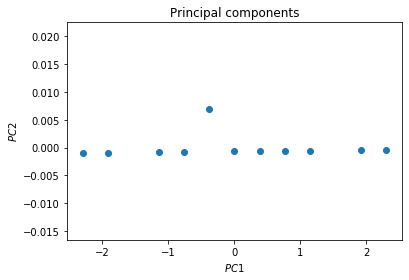

In [19]:
pca_example_trf = pca.transform(scaled_pca_example) 
fig2, ax2 = plt.subplots()
ax2.scatter(pca_example_trf[:,0], pca_example_trf[:,1])
ax2.set_ylabel('$PC2$')
ax2.set_xlabel('$PC1$')
ax2.set_title('Principal components')
plt.show()

The anomaly is evident.

### Analysis

Now we'll proceed more formally. We create a function to carry out PCA on 2D data following the five steps we outlined at the beginning of this section.

Instead of doing the centering and mean normalization ourselves, we will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) built into scikit-learn.

In [20]:
def get_1d_projected_vectors(obs, pca_object):
    # Note: The projection of vector a (data) along vector b (PC1)
    # is given by  [b / len(b)]* (len (a) cos (theta))
    # where theta is the angle between and b and the term in 
    # square parenthesis is a unit vector in the b direction
    #
    # Since cos (theta) = dot(a,b)/(len(a)len(b))
    # the projection can be written as
    # projs = b*[dot(a,b)/len(b)^2]
    #
    # The term in square parethenses is y_lengths
    # The projs is calculated adding back the mean
    # subtracted previously to center the data
    #
    # This is a very explicit way of handling the calculation.
    # See notes in "higher dimension" to see a way of generalizing
    # this to higher dimensions, while encapsulating the vector math.
    ssX = StandardScaler()
    centered_data = ssX.fit_transform(obs)
    pca_dirs = pca_object.components_
    
    y_lengths = centered_data.dot(pca_dirs.T) / pca_dirs.dot(pca_dirs.T)
    centered_projs = y_lengths*(pca_dirs)
    
    # Return the data to its original uncentered (and unscaled) positions
    return ssX.inverse_transform(centered_projs)

def do_pca_anomaly_scores(obs, pca_object):
    projected_vectors = get_1d_projected_vectors(obs, pca_object)    
    return nla.norm(obs-projs, axis=1)

In [21]:
def do_1d_pca_anomaly_scores(obs):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_ylabel('$X_2$')
    ax.set_xlabel('$X_1$')
    ax.set_title('Original data with PCA')
    
    # draw data
    ax.scatter(*obs.T, label='data')

    # Step 1: center and scale the data
    ssX = StandardScaler()
    centered_data = ssX.fit_transform(obs)
    mean = ssX.mean_
    
    #for completeness, show mean on plot
    ax.scatter(*mean.T, c='k', marker='^', label='mean') 

    # Step 2: compute prinicpal components
    # Here we focus on first PC  (greatest proportion of variance)
    pca = decomp.PCA(n_components=1)
    pca.fit_transform(centered_data)
    pca_dirs = pca.components_

    # draw principal components
    pca_endpoints = np.r_[-3.5*ssX.inverse_transform(pca_dirs),
                           3.5*ssX.inverse_transform(pca_dirs)]
    ax.plot(*pca_endpoints.T, 'y', label='PC1')

    # Step 3: Project our examples onto the PCs
    # 
    projs = get_1d_projected_vectors(obs, pca)
    ax.plot(*projs.T, 'r.', label='projected data')
    ax.legend(loc='best')
    
    # Step 4: Calculate distance between original and projected examples
    # Step 5: Use the distance to score the anomalies
    # The distance is the Euclidean norm and 
    # we use it as the anomaly score
    return nla.norm(obs-projs, axis=1)

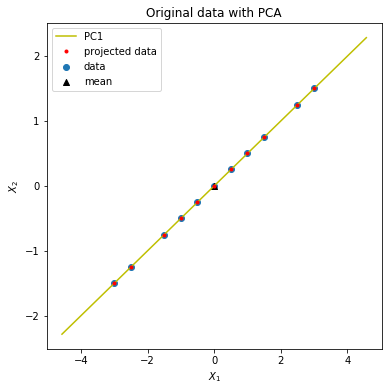

In [22]:
pca_example_scores = do_1d_pca_anomaly_scores(pca_example)

The plot shows that data (blue), the data projected onto PC1 (red points on yellow line) and the mean of the data used for centering (black triangle). By construction, PC1 passes through the mean, which is located at (0,0)--hard to see because there are a data point and a projected data point there too. 

Because the data lies very close to PC1, it is hard to see the anomaly. Therefore, we look at the anomaly scores. 

In [23]:
print(pca_example_scores)

[0.0006 0.0006 0.0008 0.0009 0.0009 0.001  0.0101 0.0012 0.0012 0.0014
 0.0015]


We see one score (0.0101) which is much larger than the others. To what point does it correspond? 

In [24]:
print(pca_example[np.argmax(pca_example_scores)])

[0.5  0.26]


It is the anomaly in the data. PCA worked!

We repeat the analysis with noisier data: two Gaussian clusters seeded with two anomalies at (6.0, 6.0) and (0.0, 10.0).

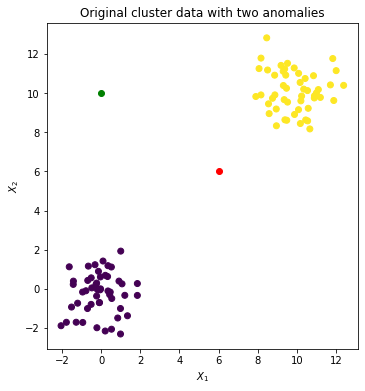

In [25]:
blobs_X, y = sk_data.make_blobs(centers=[[0,0], [10,10]])
figure, axes = plt.subplots(figsize=(6,6))
axes.scatter(*blobs_X.T, c=y)

spike_1 = np.array([[6.0,6.0]]) # Anomaly 1
spike_2 = np.array([[0.0,10]])  # Anomaly 2
axes.scatter(*spike_1.T, c='r')
axes.scatter(*spike_2.T, c='g')
axes.set_aspect('equal')
axes.set_ylabel('$X_2$')
axes.set_xlabel('$X_1$')
axes.set_title('Original cluster data with two anomalies')

# Combine the data so that the last two points are the anomalies
cluster_data = np.concatenate([blobs_X, spike_1, spike_2])


Carry out PCA


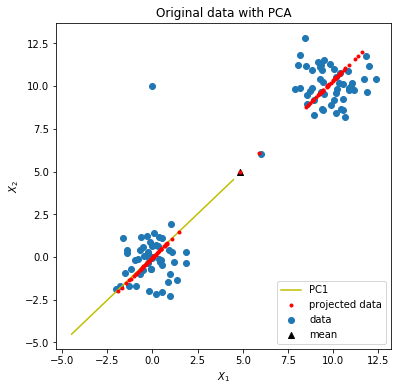

In [26]:
cluster_data_scores = do_1d_pca_anomaly_scores(cluster_data)

With this dataset, the difference between the original data and the projected data is apparent--only some of the variation in the data can be explained by projecting it onto a line. (Note that the mean (black triangle) gets projected onto PC1 as well.)

Look at the anomaly scores.

In [27]:
print(cluster_data_scores)
print(cluster_data_scores.shape)

[1.1955 0.4972 1.0317 1.0599 0.7499 0.8664 0.0176 1.6152 0.4443 0.48
 1.0706 0.1937 0.1945 0.336  0.5185 0.3551 0.0321 1.0379 0.52   0.8903
 1.5986 0.3957 0.6023 0.0592 1.6798 1.3481 0.4938 1.4255 1.8368 1.4939
 0.5484 0.0238 1.2131 0.1537 1.1705 0.4874 0.4066 0.2105 0.168  0.3102
 0.4716 0.2381 0.8287 0.5615 0.8643 0.7267 1.159  1.2343 0.4    0.5986
 0.6253 0.6488 1.307  0.8089 2.3438 2.0436 0.881  1.0887 1.3794 0.0029
 0.6403 0.428  1.1105 1.6622 1.1142 0.7853 0.0739 1.1838 0.2303 0.1333
 0.7036 0.121  1.1739 0.3849 0.3503 1.2359 0.3947 0.8203 0.4908 1.9847
 1.9663 0.4192 2.8539 1.5353 2.2853 0.4193 0.0411 0.2956 1.324  0.9315
 0.9621 0.3269 1.617  0.7744 0.5273 1.7839 0.9484 0.0507 0.3682 1.8941
 0.1236 6.9755]
(102,)


The point with the highest scored is one of our seeded anomalies.

In [28]:
print(max(cluster_data_scores))
print(cluster_data[np.argmax(cluster_data_scores)])

6.975486024690396
[ 0. 10.]


Because of the way we constructed our dataset, we know that the last two points are the anomalies. 

The one at (0.0, 10.0), which has index=101, is the one we found above. 

The other one (6.0, 6.0), with index=100, has an anomaly score of 0.0886, which is very low. This is because it lies very close to PC1.


This example shows the limitations of PCA for anomaly detection with clustered data. For such data, proximity methods should also be tried (see lesson 4). 

## Higher dimensions

In the function `do_pca_anomaly_scores` we called the helper function `get_projected_vectors` which found the projection of the vectors in our dataset onto the principal direction. By subtracting the projected vector from the original vector, we could find the length of the orthogonal components that we used to score. 

The approach used worked with one principal direction, and relied heavily on vector math. We can ask the (fitted) `pca` object to do the heavy lifting for us:
1. `reduced = pca.tranform(X)` will take our $N$-dimensional vectors, and project them onto the $d$-dimensional subspace. In our example, $N=2$ and $d=1$.
2. `projected = pca.inv_transform(reduced)` will embed the reduced vectors back into our $N$-dimensional subspace
3. `X - projected` are the components of the vectors that don't lie in our subspace.

In [29]:
def get_projected_vectors(X, pca, ssX=None):
    if not ssX:
        ssX = StandardScaler().fit(X)
    centered_data = ssX.transform(X)
    reduced = pca.transform(centered_data)
    # To get back to the original space, we need to undo the PCA
    # as well as undo the scaling/centering step.
    return ssX.inverse_transform(pca.inverse_transform(reduced))

In [30]:
# Show that it does the same thing as the previous version
def do_pca_anomaly_scores(obs, n_components=1):
    ssX = StandardScaler()
    centered_data = ssX.fit_transform(obs)
    pca = decomp.PCA(n_components=n_components)
    pca.fit(centered_data)
    
    projected_vectors = get_projected_vectors(obs, pca)
    return nla.norm(obs - projected_vectors, axis=1)

# check that the two answers agree
do_pca_anomaly_scores(pca_example) - pca_example_scores

array([ 0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.])

Our higher dimensional analog returns the same result as doing the vector arithmetic manually!

# Section 3: One-class support vector machine (SVM)

In this section, we will use the cluster dataset we created in the previous section to detect anomalies using one-class SVM. We'll apply what we've learned to a real-world dataset in the exercises.

As we discussed in the lecture, one-class SVM tries to find the hyperplane with the largest separation between the normal and anomaly classes. Typically, the data is not used as is, but transformed using the "kernel trick" (see lecture). 

We will use the one-class SVM implemented in *sklearn*, which uses the radial basis function (RBF) by default. The input for the RBF kernel is the parameter *gamma* and we use its default value as well.
(A discussion of kernel is beyond the scope of this lesson. For more information, see
https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM)



One-class SVM typically returns anomalies (-1) or normal points (+1).  We, however, are interested in scoring our points and then ranking them by score.  Therefore, we will use the `decision_function` provided which returns the signed distance to separating hyperplane (negative distances are anomalies). To be consistent with out previous convention, where larger positive scores reflect more anomalous points, we need to take the negative of the `decision_function` .

In [31]:
def do_svm_anomaly_scores(obs):
    
    oc_svm = svm.OneClassSVM(gamma='auto').fit(obs)
    scores = oc_svm.decision_function(obs).flatten()
    
    # Find the largest score and use it to normalize the scores
    max_score = np.max(np.abs(scores))
    
    # scores from oc_svm use "negative is anomaly"
    # To follow our previous convention
    # we multiply by -1 and divide by the maximum score to get scores
    # in the range [-1, 1] with positive values indicating anomalies
    return - scores / max_score

Apply the one-class SVM to the cluster dataset of the previous section.
Look at both the raw scores and the top five points (by score).

In [32]:
print(do_svm_anomaly_scores(cluster_data))
print (do_svm_anomaly_scores(cluster_data).argsort()[-5:])

[ 0.0263  0.0001 -0.0042 -0.0427 -0.0772 -0.0629 -0.0123  0.      0.0438
 -0.0834  0.0222  0.3657 -0.0209 -0.     -0.0097 -0.0773 -0.0184  0.1257
 -0.0126 -0.0728  0.0328 -0.0077 -0.      0.      0.0258 -0.      0.
  0.0109  0.251  -0.     -0.0162 -0.0068  0.1125 -0.0234  0.2469 -0.
 -0.0278  0.0238 -0.0451  0.4905  0.0548  0.0447 -0.0429  0.0165  0.2689
  0.004   0.0556  0.0227 -0.0557 -0.0008  0.2203  0.4865  0.0337 -0.0044
  0.2697  0.1895 -0.021  -0.0249 -0.     -0.0003 -0.0162  0.0129  0.0024
  0.3335  0.3076 -0.0656  0.1147  0.0586 -0.0694 -0.0187 -0.0191  0.1964
 -0.0248 -0.     -0.003  -0.0452 -0.0078 -0.0459 -0.0167  0.3697  0.2178
 -0.0223  0.6605  0.2575  0.2758  0.0097 -0.0036 -0.022   0.1218 -0.0148
 -0.0095 -0.001   0.0748  0.035  -0.0079  0.0628  0.0565 -0.0235 -0.0459
  0.1442  0.9997  1.    ]
[ 51  39  82 100 101]


The two seeded anomalies (index=100 and 101) are the two highest ranked points. The performance is better than PCA, but the process of anomaly detection is less transparent.

## Exercises

### Data

For all of the exercises, we will use a real-world dataset: the `ionosphere` dataset from the UCI Machine Learning Database repository. 
This dataset consists of radar returns from the ionosphere and was originally used to classify the returns as good (suitable for further research) or bad. More information is available here: https://archive.ics.uci.edu/ml/datasets/ionosphere.

For the purposes of this notebook, we have adapted the dataset for anomaly detection. We removed two columns: one with the class labels (good or bad) and another which was a constant (0) for all data instances. 

We read the data in as a pandas dataframe and then place it in numpy array for compatibility with our existing functions

In [33]:
ion_df = pd.read_csv('ionosphere_data.csv', header=None)
ion_data = np.array(ion_df.values)

Look at the data

In [34]:
ion_data.shape

(351, 33)

In [35]:
print(ion_data)

[[ 1.      0.9954 -0.0589 ... -0.5449  0.1864 -0.453 ]
 [ 1.      1.     -0.1883 ... -0.0629 -0.1374 -0.0245]
 [ 1.      1.     -0.0336 ... -0.2418  0.5605 -0.3824]
 ...
 [ 1.      0.947  -0.0003 ...  0.0044  0.927  -0.0058]
 [ 1.      0.9061 -0.0166 ... -0.0376  0.874  -0.1624]
 [ 1.      0.8471  0.1353 ... -0.0668  0.8576 -0.0615]]


### Exercise #1

This exercise refers to Section 1 (linear regression model)
 
For the ionosphere dataset, there isn't a natural dependent variable, so we have to choose one. Create a function `linreg_anomaly_scores` that returns the anomalies scores of a linear regression model where two inputs are provided: the data and the index of the feature that is the dependent variable. We will use this function in Exercise 4 to analyze the ionosphere data.



**Note 1:** Note that since we don't have separate training data, for simplicity you should score the anomalies on all of the data.

**Note 2:** You may wish to use the following helper function. For data with _n_ features, it returns an array of length _n_ with all entries `False` except for a single `True` values at a specified index (_idx_).

In [36]:
def idx_to_boolean(n, idx):
    select = np.zeros(n,dtype=np.bool)
    select[idx] = True
    return select

In [37]:
# YOUR CODE HERE

### Exercise #2

This exercise refers to Section 2 (PCA).

Create a function `pca_anomaly_scores` that  returns the anomalies scores of a PCA model where two inputs are provided: the data and the number of components. We will use this function in Exercise 4 to analyze the ionosphere data.

In [38]:
# YOUR CODE HERE

### Exercise #3

This exercise refers to Section 3 (one-class SVM).

Create a function `svm_anomaly_scores` that returns the anomalies scores of a one-class SVM model where two sets inputs are provided: the data and a kernel. We will use this function in Exercise 4 to analyze the ionosphere data.

In [39]:
# Choose the default kernel to be linear

# YOUR CODE HERE

### Exercise #4

We now have three `[method]_outlier_scores` functions.  Apply each of them to the ionosphere dataset.  What are the top five most anomalous examples using each technique?

In [40]:
methods = [linreg_anomaly_scores,
           pca_anomaly_scores,
           svm_anomaly_scores]

# YOUR CODE HERE

NameError: name 'linreg_anomaly_scores' is not defined

Three different methods, three different answers. Therefore more exploration is needed, which we encourage the reader to pursue. For example, choosing different target feature for the linear regression; increase the number of components in PCA; or change the kernel for one-class SVM. 

The last suggestion can be implemented readily for the RBF kernel, since we used it in Section 3.


In [ ]:
print(sorted(do_svm_anomaly_scores(ion_data).argsort()[-5:]))

Same as for PCA with one component.

# Summary

In this assignment you should have learned: 

1. How to apply linear regression models
2. How to apply PCA
3. How to apply one-class SVMs

Congratulations! This concludes the lesson.

In [ ]:
print('end')